# HDS-M04: Deep Learning in Medical Imaging

HealthDataScience CDT Users Guide (how to access VM) <br>
[Setup instructions](https://canvas.ox.ac.uk/courses/151592/files/4750711?wrap=1)


### Required packages

[1] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[2] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

[3] [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html) is used to visualise your training and validation loss and accuracy development - It is important to observe it!!!

[4] [TorchVision](https://pytorch.org/vision/stable/index.html) you can use available datasets that include one you are required to use in this tutorial (CIFAR10) and also use augmentations (meaning you can increase data variability for improved accuracy and model generalisation)

[5] [Scikit-learn] Metrics

**Reference:** 

[1] Original U-Net paper: https://arxiv.org/pdf/1505.04597.pdf

[2] Link to presentation: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/


**What will you learn here?**

- You wil learn how to load your custom data for semantic segmentation task

- You will make an encoder-decoder U-Net architecture 

- You will learn how to group repeated blocks into one while designing U-Net

<img src="https://i.stack.imgur.com/EtyQs.png" style="width:800px;height:400px;">
<caption><center> <u>Figure</u>: U-Net architecture for image segmentation.</center></caption>

**Concentrate on:**

[1] Encoder layers (this is similar to your classification exercise)

[2] Decoder layers (upscaling of images occur here as you want to obtain per-pixel segmentation)

In [1]:
import torch
import torchvision 
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
# always check your version
print(torch.__version__)

2.2.0+cu121


#### New : We will setup a seed for reproducibility (ask tutor if you do not understand it)
- Setting a seed helps to regenerate the same result

In [2]:
import random
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

### Data loading and pre-processing
**Steps**

[1] Load data - data is provided already available for you to use in ``/cdtshared/Cohort-2021/HDS-M05/segmentation/MontgomerySet``
- Images are in folder ``/cdtshared/Cohort-2021/HDS-M05/segmentation/MontgomerySet/CXR_png``
- Corresponding masks:
    - Left Mask in ``/cdtshared/Cohort-2021/HDS-M05/segmentation/MontgomerySet/ManualMask/leftMask``
    - Right Mask in ``/cdtshared/Cohort-2021/HDS-M05/segmentation/MontgomerySet/ManualMask/rightMask``
- Data format and size: All are in ``.png`` and of variable size (please resize to 256x256) for your practicals

[2] Transform --> Normalise your data - mean and std (e.g., if color then normalise all three channels)
e.g., torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

[3] Transform --> Always convert data to ToTensor (you can do **step 1, 2 and 3** in one line as done in this tutorial)

[4] New: split your data into **train, validation, and test set**

[4] Make [DataLoaders](https://pytorch.org/docs/stable/data.html): It represents a Python iterable over a dataset

[5] Identify labels 


In [24]:
from torchvision import transforms 
from torch.utils.data import DataLoader

In [34]:
from PIL import Image # For reading your custom data images
import os
import glob

# Load data and include prepared transform (Remember to apply same transform to both image and label) 
class mySegmentationData(object):
    def __init__(self, root, transforms = None):
        self.root = root
        self._eval = eval
        self.transforms = transforms
        self.build_dataset()
        
    def build_dataset(self):   
        self.imgs = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "imagesTr")
        self.masks = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "labelsTr_255")
        
        self._images = sorted(glob.glob(self.imgs + "/*.png"))
        
#       Note: Here we are using only left lung data today
        self._labels = sorted(glob.glob(self.masks  + "/*.png"))
        
    def __getitem__(self, idx):
    
        img = Image.open(self._images[idx]).convert("RGB").resize((256,256), resample=0)
        mask = Image.open(self._labels[idx]).convert("L").resize((256, 256), resample=0)
        mask = Image.fromarray(((np.asarray(mask)).astype('float32')).astype('uint8'))
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
   
        return img, mask
    
    def __len__(self):
        return len(self._images)

#### New: You will split train data into train and val set (say 90-10) 
- This step is crucial to identify under- and over-fitting problems 
- Later, we will visualise performance on both train and test online during training (using tensorboard)

In [35]:
# Step: Split between train, val, and test from the overall trainset
transform = transforms.Compose([transforms.ToTensor()])
# transforms.Resize((256,256))
trainset = mySegmentationData(root='./data', transforms=transform)

#  same as you did in classification (here we are doing )
from torch.utils.data.sampler import SubsetRandomSampler
val_percentage = 0.2
num_train = len(trainset)

indices = list(range(num_train))
split = int(np.floor(val_percentage * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


print(len(train_sampler))

# Now create data loaders (same as before)
# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 4 # create batch-based on how much memory you have and your data size

traindataloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valdataloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler,
            num_workers=0,)


2076


In [27]:
print('Number of training samples:', len(traindataloader))
print('Number of validation samples:', len(valdataloader))
# print('Number of testing samples:', len(testdataloader))

Number of training samples: 519
Number of validation samples: 130


### Look into data

In [28]:
import matplotlib.pyplot as plt
# function to unnormalise images and using transpose to change order to [H, W, Channel] 
def imshow(img):
    # TODO: unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

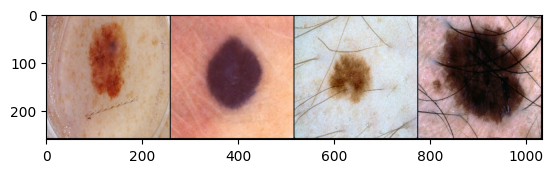

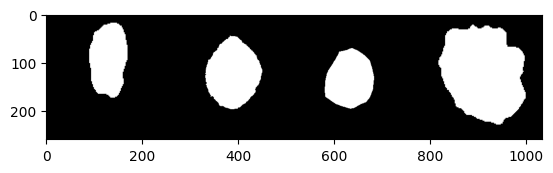

In [36]:
%matplotlib inline

# always check the shape of your training data
dataiter = iter(traindataloader)
images, masks = next(dataiter)

# show images 
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(masks))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


### Create your UNet model
- Please note that your input image size will make difference on your hard-coded feature sizes in FC-layer
- Always be aware of what size input is used, here for convenience we will follow the original paper and reshape image to 224x224x3 

<img src="https://i.stack.imgur.com/EtyQs.png" style="width:800px;height:400px;">
<caption><center> <u>Figure</u>: U-Net architecture for image segmentation.</center></caption>

**Hint**
- You will make an encoder-decoder U-Net architecture 
    - Make a baseblock with --> two convolution with kernel_size 3 and padding 1 with relu 
    - Make another output block with 1 convolution
    - For encoder you will use maxpooling with kernel 2
    - For decoder you will use upsampling using nn.Upsample (scale_factor=2) or ConvTranspose2d
    - Both encoder and decoder will have **baseblock**
    

- You will learn how to group repeated blocks into one while designing U-Net

#### Basic convolution layer -- 2 convs concatenated

In [37]:
# Step 1: Build a nn.Sequential with two conv-BatchN-Relu layers
def baseblock(channel_in, channel_out):
#     Design a baseblock with conv-batch-relu x 2 (each input is twice convolved as in fig.)
    return nn.Sequential(
        nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
        nn.BatchNorm2d(channel_out),
        nn.ReLU(inplace=True),
        nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
        nn.BatchNorm2d(channel_out),
        nn.ReLU(inplace=True)
    )  

# Step 2: Build a downscaling module [Hint: use the above layeredConv after that]
# Add a maxpool before baseblock as in figure
def downsamplePart(channel_in, channel_out):
    return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            baseblock(channel_in, channel_out)
        )

# Step 3: Build a upscaling module [Hint: use the above layeredConv after that]
# - Remember there is also concatenation and size may change so we are padding
class upsampledPart(nn.Module):
    def __init__(self, channel_in, channel_out, bilinear=True):
        super().__init__()
        #self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True)
        self.up = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=2, stride=2)
        self.conv = baseblock(channel_in, channel_out)
        
    def forward(self, x1, x2):
        # upscale and then pad to eliminate any difference between upscaled and other feature map coming with skip connection     
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2] )
        
        # concatenate (perform concatenation of x1 and x2 --> remember these are skip x2(from encoder) and upssampled image x1)
        x = torch.cat([x2, x1], dim=1)
        
        # apply baseblock after concatenation --> you do again two convs.? --> baseblock
        x = self.conv(x)

        return x
    
# Step 4: Compile all of above together
# here output channel should be equal to number of classes
class UNet(nn.Module):
    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet,self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        #call your base block
        self.initial = baseblock(channel_in, 64)
        
        # downsampling layers with 2 conv layers
        self.down1 = downsamplePart(64, 128)
        self.down2 = downsamplePart(128, 256)
        self.down3 = downsamplePart(256, 512)
        self.down4 = downsamplePart(512, 1024)
        
        # your code here
        # upsampling layers with feature concatenation and 2 conv layers 
        self.up1 = upsampledPart(1024, 512) 
        self.up2 = upsampledPart(512, 256)
        self.up3 = upsampledPart(256, 128)
        self.up4 = upsampledPart(128, 64)
        
        # output layer
        self.out = nn.Conv2d(64, channel_out, kernel_size=1) 

    # build a forward pass here
    # remember to keep your output as you will need to concatenate later in upscaling
    def forward(self,x):
        x1 = self.initial(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # your code here for upscaling
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # output
        return self.out(x)  

### Training your model

### Prepare an optimizer, set learning rate, and you loss function
- Here you will use model.train and use gradients
- Also, you will use criterion to compute loss 
- Compute metric to know how well it is performing
- save them to display mean for each epoch

In [42]:
# call you model 
model = UNet(channel_in=3, channel_out= 1)
lr = 0.001
# optimiser = optim.Adam(model.parameters(), lr=lr)
# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# optimiser = torch.optim.RMSprop(model.parameters(), lr = lr, weight_decay = 1e-8, momentum=0.9)
# TODO: you can try with different loss function
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

### Prepare accuracy computation to know how your training is going 

[1] Loss function is important to keep track (mostly you minimise it, i.e. it should go down)

[2] Accuracy in classification is important and you want higher accuracy

[3] You can use TensorBoard to visualize 

In [43]:
# Create metrics
def dice(a, b):
    """Calculate dice score for each image in tensor"""
    # a and b are tensors of shape (B, C, H, W)
    # Sum over last two axes (H and W i.e. each image)
    return 2*(a*b).sum(axis=[-2, -1])/(a + b).sum(axis=[-2,-1]).type(torch.float32)

def mask_out(out):
    """Mask tensor/array with 0 threshold"""
    # Need to binarize the output to be able to calculate dice score
    return out > 0

def get_dice_arr(out, label):
    """Get dice score for each image in the batch for each mask seperately"""
    # Output is shape (B, C)
    return dice(mask_out(out), label)

In [44]:
# Training & validation: same as your classification task!!
model.to(device)
model.train()
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# define no. of epochs you want to loop 
epochs = 10
log_interval = 100 # for visualising your iterations 

# New: savining your model depending on your best val score
best_valid_loss = float('inf')
ckptFileName = 'UNet_CKPT_best.pt'
for epoch in range(epochs):
    train_loss, valid_loss, train_dsc,val_dsc  = [], [], [], []
    
    for batch_idx, (data, label) in enumerate(traindataloader):
        # initialise all your gradients to zer

        label = label.to(device)
        optimiser.zero_grad()
        out = model(data.to(device))

        loss = criterion(out, label)
        loss.backward()
        optimiser.step()
        
        # append
        train_loss.append(loss.item())
        acc_1 = get_dice_arr(out, label.to(device))
        train_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())
        
        if (batch_idx % log_interval) == 0:
            print('Train Epoch is: {}, train loss is: {:.6f} and train dice: {:.6f}'.format(epoch, np.mean(train_loss),np.mean(train_dsc)))
        
            with torch.no_grad():
                for i, (data, label) in enumerate(valdataloader):
                    data, label = data.to(device), label.to(device)
                    out = model(data)
                    loss = criterion(out, label.to(device))
                    acc_1 = get_dice_arr(out, label.to(device))

                    # append
                    val_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())
                    valid_loss.append(loss.item())
    
            print('Val Epoch is: {}, val loss is: {:.6f} and val dice: {:.6f}'.format(epoch, np.mean(valid_loss), np.mean(val_dsc)))
    
    # Uncomment it to save your epochs
    if np.mean(valid_loss) < best_valid_loss:
        best_valid_loss = np.mean(valid_loss)
        print('saving my model, improvement in validation loss achieved...')
        torch.save(model.state_dict(), ckptFileName)
        
        
    # every epoch write the loss and accuracy (these you can see plots on tensorboard)        
    writer.add_scalar('UNet/train_loss', np.mean(train_loss), epoch)
    writer.add_scalar('UNet/train_accuracy', np.mean(train_dsc), epoch)
    
    # New --> add plot for your val loss and val accuracy
    writer.add_scalar('UNet/val_loss', np.mean(valid_loss), epoch)
    writer.add_scalar('UNet/val_accuracy', np.mean(val_dsc), epoch)
    
writer.close()

Train Epoch is: 0, train loss is: 0.731322 and train dice: 0.218845
Val Epoch is: 0, val loss is: 0.610745 and val dice: 0.460441


KeyboardInterrupt: 

In [ ]:
### TODO: compute the accuracy of your model on validation set --> You are required to use dice similarity coefficient
total = 0
model.eval()
dataiter = iter(valdataloader)
images, masks = dataiter.next()
output = model(images.to(device))
# show images 
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(output.detach().cpu()))

In [8]:
class myTestData(object):
    def __init__(self, root, transforms = None):
        self.root = root
        self._eval = eval
        self.transforms = transforms
        self.build_dataset()
        
    def build_dataset(self):   
        self.imgs = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "imagesTs")
        self.masks = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "labelsTs")
        
        self._images = sorted(glob.glob(self.imgs + "/*.png"))
        
#       Note: Here we are using only left lung data today
        self._labels = sorted(glob.glob(self.masks  + "/*.png"))
        
    def __getitem__(self, idx):
    
        img = Image.open(self._images[idx]).convert("RGB").resize((256,256), resample=0)
        mask = Image.open(self._labels[idx]).convert("L").resize((256, 256), resample=0)
        mask = Image.fromarray(((np.asarray(mask)).astype('float32')).astype('uint8'))
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
   
        return img, mask
    
    def __len__(self):
        return len(self._images)

In [39]:
# Apply on your 10% validaton data and report your result
from myUNet_utils import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckptFileName = 'UNet_CKPT_best.pt'
# load the saved weights
model = UNet(channel_in=3, channel_out= 1).to(device)
model.load_state_dict(torch.load(ckptFileName))

transform = transforms.Compose([transforms.ToTensor()])
# transforms.Resize((256,256))
testset = myTestData(root='./data', transforms=transform)
testdataloader = DataLoader(testset)

# Apply testing (same as validation above)
# Your code here... (same as validation code)
test_dsc = []

with torch.no_grad():
    for i, (data, label) in enumerate(testdataloader):
        data_image = data.squeeze().permute(1, 2, 0).numpy()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'data_' + str(i) + '.png')), data_image)
        label_image = label.squeeze().numpy()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'label_' + str(i) + '.png')), label_image, cmap='gray')
        data, label = data.to(device), label.to(device)
        out = model(data)
        probabilities = torch.sigmoid(out)
        threshold = 0.5
        binary_mask = probabilities > threshold
        grayscale_mask = binary_mask.float() * 255
        grayscale_mask = grayscale_mask.byte()
        pred_label_image = grayscale_mask.cpu().detach().numpy().squeeze()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'pred_' + str(i) + '.png')), pred_label_image, cmap='gray')
        acc_1 = get_dice_arr(grayscale_mask, label.to(device))

        # append
        test_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())


### Improving your network peerformance

- Train for larger batch size and epochs (longer)
- Add data augmentation provided in transforms (https://pytorch.org/vision/stable/transforms.html) -- Ask tutor if you  are confused 
- Save your training with augmentation as ``my_UNet_withAug.pt``
- You can use combined loss funtion as well (e.g. dice loss with BCE loss)
- Train your network by combining both left and right lung segmentation (report accuracy and loss curves)


#### Exercise: Perform above improvements on  chest X-ray imaging
- You can use this ipython notebook to do this (**Assignment to be submmitted**)
- Due on **Friday 4th November, 2022 (6.00PM, midday)** (*You will be graded for this exercise*)

<h3>Thanks for completing this lesson!</h3>
The tutorial was written by Dr A. Sharib. (revised by Bartek Papiez, Oct 2022). <br>
Any comments or feedbacks and your solution to exercise, please send to bartomiej.papiez@bdi.ox.ac.uk 

In [40]:
np.mean(test_dsc)

0.8134436